In [21]:
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Load dataset (Temporal Split)
with open("train_val_test_time.pkl", "rb") as f:
    X_train_time, X_val_time, X_test_time, y_train_time, y_val_time, y_test_time = pickle.load(f)

print("Data (Time) successfully loaded!")

# Load dataset (Random Split)
with open("train_val_test_random.pkl", "rb") as f:
    X_train_rand, X_val_rand, X_test_rand, y_train_rand, y_val_rand, y_test_rand = pickle.load(f)

print("Data (Random) successfully loaded!")


Data (Time) successfully loaded!
Data (Random) successfully loaded!


In [22]:
# Convert categorical features to category dtype for XGBoost
categorical_features = ["purpose", "emp_length"]
for col in categorical_features:
    X_train_rand[col] = X_train_rand[col].astype("category")
    X_val_rand[col] = X_val_rand[col].astype("category")
    X_test_rand[col] = X_test_rand[col].astype("category")
    X_train_time[col] = X_train_time[col].astype("category")
    X_val_time[col] = X_val_time[col].astype("category")
    X_test_time[col] = X_test_time[col].astype("category")

print("Categorical processing complete.")


Categorical processing complete.


In [23]:
print(X_train_time.dtypes.to_string())


acc_open_past_24mths           float64
all_util                       float64
annual_inc                     float64
application_type                 int64
avg_cur_bal                    float64
bc_open_to_buy                 float64
bc_util                        float64
dti                            float64
delinq_2yrs                    float64
emp_length                    category
fico_range_high                float64
fico_range_low                 float64
il_util                        float64
inq_fi                         float64
inq_last_12m                   float64
inq_last_6mths                 float64
installment                    float64
loan_amnt                      float64
max_bal_bc                     float64
mo_sin_old_il_acct             float64
mo_sin_old_rev_tl_op           float64
mo_sin_rcnt_rev_tl_op          float64
mo_sin_rcnt_tl                 float64
mort_acc                       float64
mths_since_rcnt_il             float64
mths_since_recent_bc     

In [24]:
print(X_train_rand.dtypes.to_string())

acc_open_past_24mths           float64
all_util                       float64
annual_inc                     float64
application_type                 int64
avg_cur_bal                    float64
bc_open_to_buy                 float64
bc_util                        float64
dti                            float64
delinq_2yrs                    float64
emp_length                    category
fico_range_high                float64
fico_range_low                 float64
il_util                        float64
inq_fi                         float64
inq_last_12m                   float64
inq_last_6mths                 float64
installment                    float64
loan_amnt                      float64
max_bal_bc                     float64
mo_sin_old_il_acct             float64
mo_sin_old_rev_tl_op           float64
mo_sin_rcnt_rev_tl_op          float64
mo_sin_rcnt_tl                 float64
mort_acc                       float64
mths_since_rcnt_il             float64
mths_since_recent_bc     

## Improved Model Training (Random)

In [25]:
import xgboost as xgb
import numpy as np

# Calculate class imbalance for proper weighting
class_counts = np.bincount(y_train_rand)
print(f"Class distribution: {class_counts}")
# scale_pos_weight gives more weight to the minority class (defaults)
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# Initialize XGBoost classifier with evaluation enabled
xgb_model_rand = xgb.XGBClassifier(
    objective="multi:softmax",  
    num_class=len(y_train_rand.unique()),  
    tree_method="hist",  
    enable_categorical=True,  
    use_label_encoder=False,  
    reg_alpha=5,  
    reg_lambda=2,  
    learning_rate=0.05,  
    max_depth=4,  
    min_child_weight=3,  
    n_estimators=500,  
    early_stopping_rounds=450,  
    eval_metric=["mlogloss", "merror", "auc"],
    scale_pos_weight=scale_pos_weight,
)

# ✅ Train the model with evaluation enabled
xgb_model_rand.fit(
    X_train_rand, y_train_rand,
    eval_set=[(X_train_rand, y_train_rand), (X_val_rand, y_val_rand)],  # Use train & validation set
    verbose=True  # Show progress
)

print("✅ Model training complete with evaluation results.")


Class distribution: [ 196256 1366829]
Calculated scale_pos_weight: 0.14


/Users/jiaxuanliu/anaconda3/envs/math170/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:0.66516	validation_0-merror:0.12556	validation_0-auc:0.64595	validation_1-mlogloss:0.66520	validation_1-merror:0.12602	validation_1-auc:0.64517
[1]	validation_0-mlogloss:0.63987	validation_0-merror:0.12556	validation_0-auc:0.65259	validation_1-mlogloss:0.63995	validation_1-merror:0.12602	validation_1-auc:0.65118
[2]	validation_0-mlogloss:0.61690	validation_0-merror:0.12556	validation_0-auc:0.65584	validation_1-mlogloss:0.61702	validation_1-merror:0.12602	validation_1-auc:0.65468
[3]	validation_0-mlogloss:0.59603	validation_0-merror:0.12556	validation_0-auc:0.65793	validation_1-mlogloss:0.59619	validation_1-merror:0.12602	validation_1-auc:0.65666
[4]	validation_0-mlogloss:0.57701	validation_0-merror:0.12556	validation_0-auc:0.65972	validation_1-mlogloss:0.57720	validation_1-merror:0.12602	validation_1-auc:0.65837
[5]	validation_0-mlogloss:0.55964	validation_0-merror:0.12556	validation_0-auc:0.66050	validation_1-mlogloss:0.55986	validation_1-merror:0.12602	valid

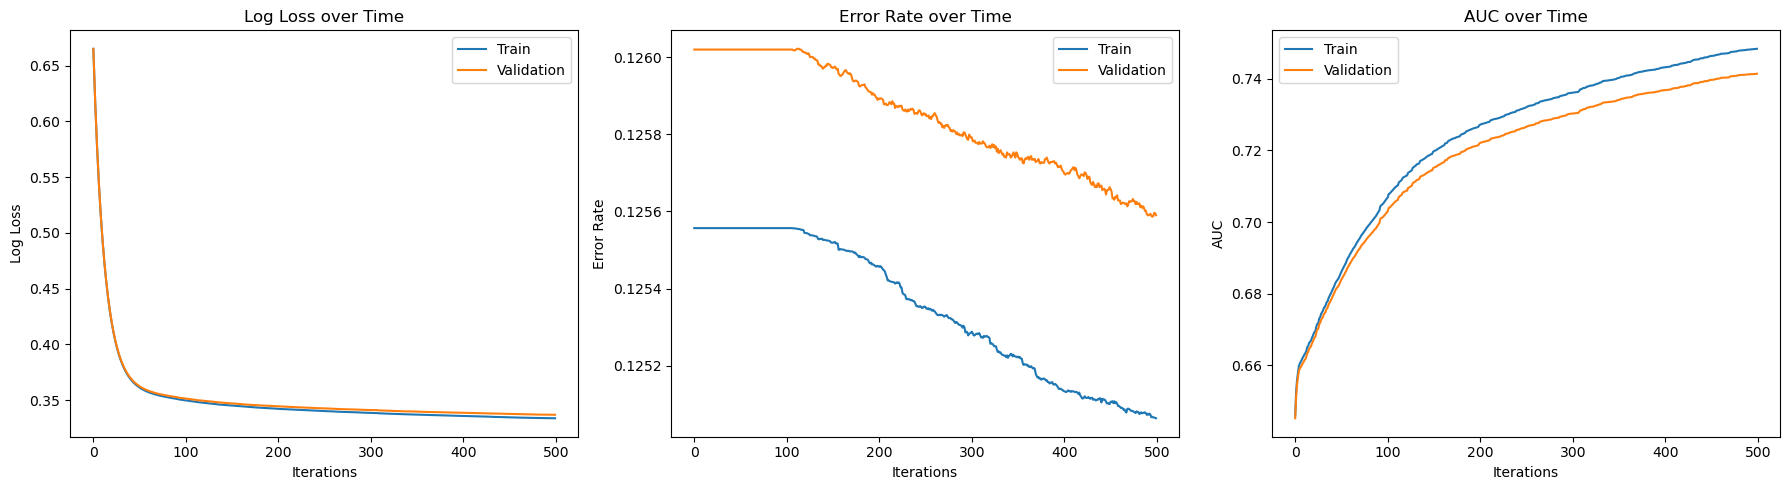

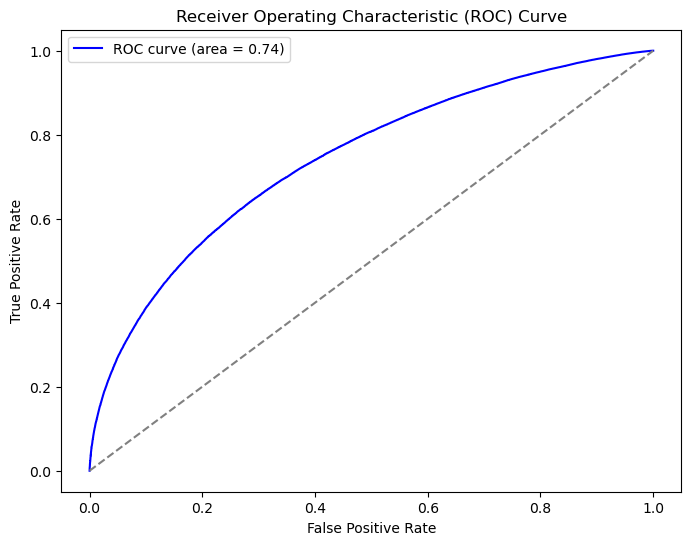

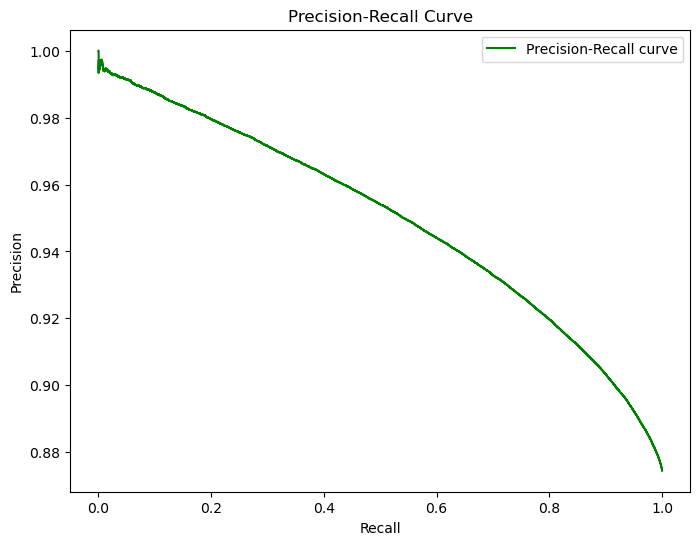

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve


# Retrieve evaluation history
results = xgb_model_rand.evals_result()

# Extract epochs
epochs = len(results["validation_1"]["mlogloss"])  # Use validation set
x_axis = range(0, epochs)

# Create figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Log Loss
axs[0].plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
axs[0].plot(x_axis, results["validation_1"]["mlogloss"], label="Validation")
axs[0].set_title("Log Loss over Time")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Log Loss")
axs[0].legend()

# Plot Error Rate
axs[1].plot(x_axis, results["validation_0"]["merror"], label="Train")
axs[1].plot(x_axis, results["validation_1"]["merror"], label="Validation")
axs[1].set_title("Error Rate over Time")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("Error Rate")
axs[1].legend()

# Plot AUC
axs[2].plot(x_axis, results["validation_0"]["auc"], label="Train")
axs[2].plot(x_axis, results["validation_1"]["auc"], label="Validation")
axs[2].set_title("AUC over Time")
axs[2].set_xlabel("Iterations")
axs[2].set_ylabel("AUC")
axs[2].legend()

plt.tight_layout()
plt.show()

# Generate ROC Curve
y_pred_prob = xgb_model_rand.predict_proba(X_test_rand)[:, 1]
fpr, tpr, _ = roc_curve(y_test_rand, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Generate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_rand, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_train_pred = xgb_model_rand.predict(X_train_rand)
y_val_pred = xgb_model_rand.predict(X_val_rand)
y_test_pred = xgb_model_rand.predict(X_test_rand)

# Compute accuracy metrics
accuracy_train = accuracy_score(y_train_rand, y_train_pred)
accuracy_val = accuracy_score(y_val_rand, y_val_pred)
accuracy_test = accuracy_score(y_test_rand, y_test_pred)

# Compute precision, recall, and F1-score for validation set
precision_val = precision_score(y_val_rand, y_val_pred, average="weighted")
recall_val = recall_score(y_val_rand, y_val_pred, average="weighted")
f1_val = f1_score(y_val_rand, y_val_pred, average="weighted")

# Display results
accuracy_results = {
    "Train Accuracy": accuracy_train,
    "Validation Accuracy": accuracy_val,
    "Test Accuracy": accuracy_test,
    "Validation Precision": precision_val,
    "Validation Recall": recall_val,
    "Validation F1-score": f1_val
}

accuracy_results


{'Train Accuracy': 0.8749364238029281,
 'Validation Accuracy': 0.874409820585458,
 'Test Accuracy': 0.8747824017473116,
 'Validation Precision': 0.8406284234390355,
 'Validation Recall': 0.874409820585458,
 'Validation F1-score': 0.8178300692431038}

In [28]:
# Get feature importance scores
feature_importance = xgb_model_rand.get_booster().get_score(importance_type="weight")

# Convert to DataFrame for better readability
importance_df = pd.DataFrame(
    feature_importance.items(),
    columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

print(importance_df.to_string())

                       Feature  Importance
53            earliest_cr_line      1460.0
16                   loan_amnt      1124.0
19        mo_sin_old_rev_tl_op      1065.0
15                 installment       988.0
18          mo_sin_old_il_acct       801.0
2                   annual_inc       607.0
10             fico_range_high       571.0
7                          dti       548.0
0         acc_open_past_24mths       472.0
9                   emp_length       465.0
49             tot_hi_cred_lim       392.0
6                      bc_util       391.0
51                     purpose       390.0
52            total_rev_hi_lim       338.0
5               bc_open_to_buy       302.0
1                     all_util       292.0
48              total_bc_limit       285.0
25       mths_since_recent_inq       279.0
46            percent_bc_gt_75       237.0
38              pct_tl_nvr_dlq       237.0
14              inq_last_6mths       226.0
24        mths_since_recent_bc       218.0
11         

## Improved Model Training (Time)


In [29]:
# Initialize XGBoost classifier with evaluation enabled
xgb_model_time = xgb.XGBClassifier(
    objective="multi:softmax",  
    num_class=len(y_train_time.unique()),  
    tree_method="hist",  
    enable_categorical=True,  
    use_label_encoder=False,  
    reg_alpha=5,  
    reg_lambda=2,  
    learning_rate=0.05,  
    max_depth=4,  
    min_child_weight=3,  
    n_estimators=500,  
    early_stopping_rounds=450,  
    eval_metric=["mlogloss", "merror", "auc"],
    scale_pos_weight=scale_pos_weight,
)

# ✅ Train the model with evaluation enabled
xgb_model_time.fit(
    X_train_time, y_train_time,
    eval_set=[(X_train_time, y_train_time), (X_val_time, y_val_time)],  # Use train & validation set
    verbose=True  # Show progress
)

print("✅ Model training complete with evaluation results.")

/Users/jiaxuanliu/anaconda3/envs/math170/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:33:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:0.67256	validation_0-merror:0.18210	validation_0-auc:0.62525	validation_1-mlogloss:0.67328	validation_1-merror:0.19443	validation_1-auc:0.62635
[1]	validation_0-mlogloss:0.65395	validation_0-merror:0.18210	validation_0-auc:0.62991	validation_1-mlogloss:0.65539	validation_1-merror:0.19443	validation_1-auc:0.63073
[2]	validation_0-mlogloss:0.63708	validation_0-merror:0.18210	validation_0-auc:0.63251	validation_1-mlogloss:0.63918	validation_1-merror:0.19443	validation_1-auc:0.63331
[3]	validation_0-mlogloss:0.62173	validation_0-merror:0.18210	validation_0-auc:0.63600	validation_1-mlogloss:0.62449	validation_1-merror:0.19443	validation_1-auc:0.63622
[4]	validation_0-mlogloss:0.60780	validation_0-merror:0.18210	validation_0-auc:0.63571	validation_1-mlogloss:0.61121	validation_1-merror:0.19443	validation_1-auc:0.63600
[5]	validation_0-mlogloss:0.59510	validation_0-merror:0.18210	validation_0-auc:0.63615	validation_1-mlogloss:0.59908	validation_1-merror:0.19443	valid

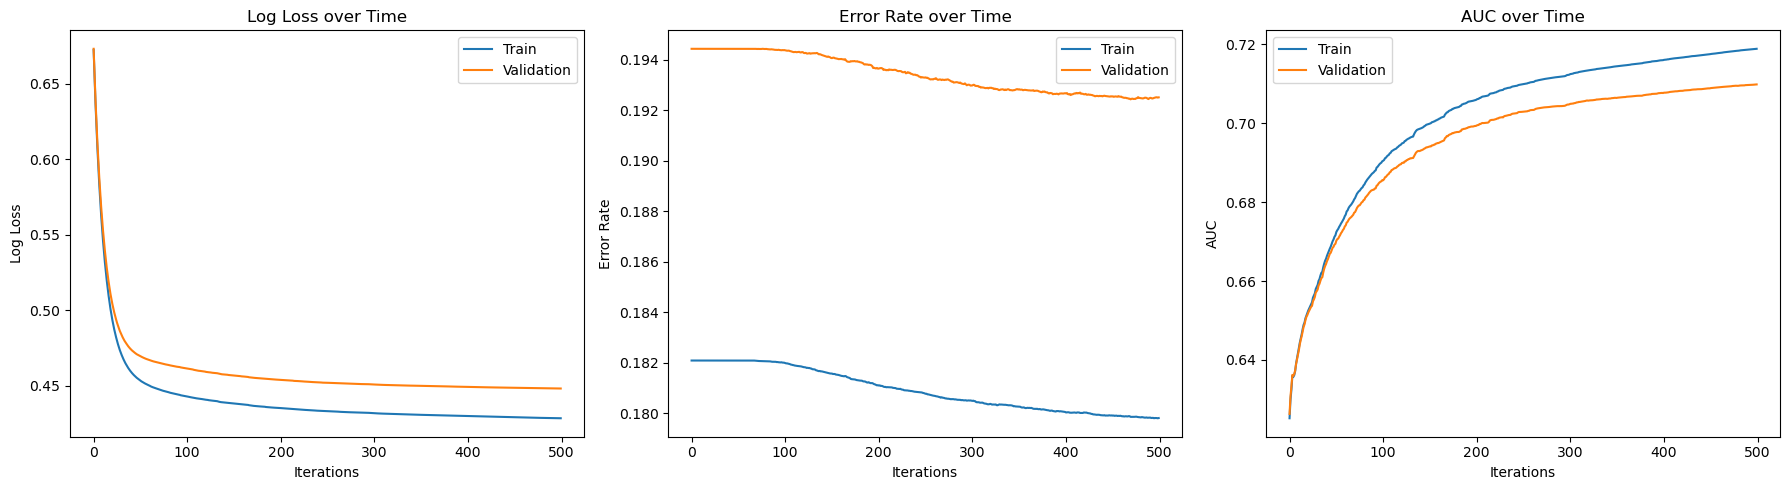

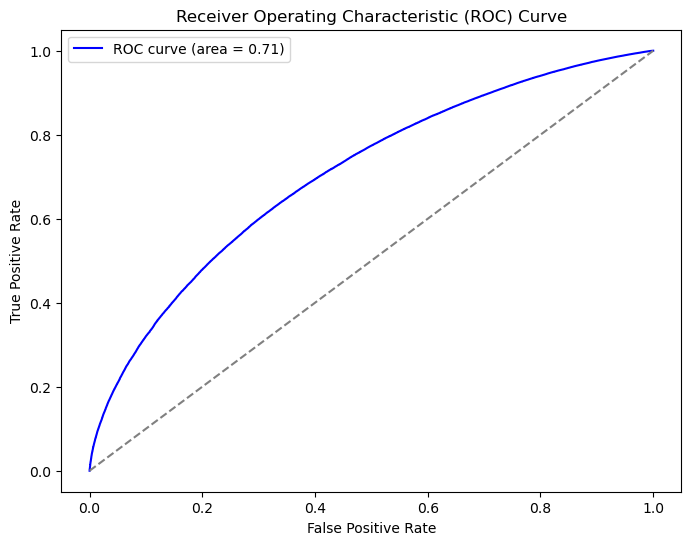

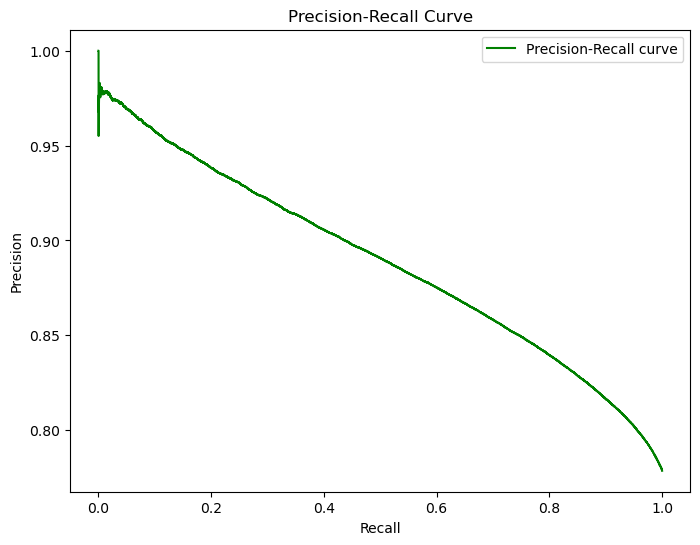

In [30]:
# Retrieve evaluation history
results = xgb_model_time.evals_result()

# Extract epochs
epochs = len(results["validation_1"]["mlogloss"])  # Use validation set
x_axis = range(0, epochs)

# Create figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Log Loss
axs[0].plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
axs[0].plot(x_axis, results["validation_1"]["mlogloss"], label="Validation")
axs[0].set_title("Log Loss over Time")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Log Loss")
axs[0].legend()

# Plot Error Rate
axs[1].plot(x_axis, results["validation_0"]["merror"], label="Train")
axs[1].plot(x_axis, results["validation_1"]["merror"], label="Validation")
axs[1].set_title("Error Rate over Time")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("Error Rate")
axs[1].legend()

# Plot AUC
axs[2].plot(x_axis, results["validation_0"]["auc"], label="Train")
axs[2].plot(x_axis, results["validation_1"]["auc"], label="Validation")
axs[2].set_title("AUC over Time")
axs[2].set_xlabel("Iterations")
axs[2].set_ylabel("AUC")
axs[2].legend()

plt.tight_layout()
plt.show()

# Generate ROC Curve
y_pred_prob = xgb_model_time.predict_proba(X_test_time)[:, 1]
fpr, tpr, _ = roc_curve(y_test_time, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Generate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_time, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [31]:
# Make predictions
y_train_pred = xgb_model_time.predict(X_train_time)
y_val_pred = xgb_model_time.predict(X_val_time)
y_test_pred = xgb_model_time.predict(X_test_time)

# Compute accuracy metrics
accuracy_train = accuracy_score(y_train_time, y_train_pred)
accuracy_val = accuracy_score(y_val_time, y_val_pred)
accuracy_test = accuracy_score(y_test_time, y_test_pred)

# Compute precision, recall, and F1-score for validation set
precision_val = precision_score(y_val_time, y_val_pred, average="weighted")
recall_val = recall_score(y_val_time, y_val_pred, average="weighted")
f1_val = f1_score(y_val_time, y_val_pred, average="weighted")

# Display results
accuracy_results = {
    "Train Accuracy": accuracy_train,
    "Validation Accuracy": accuracy_val,
    "Test Accuracy": accuracy_test,
    "Validation Precision": precision_val,
    "Validation Recall": recall_val,
    "Validation F1-score": f1_val
}

accuracy_results


{'Train Accuracy': 0.8201813878600402,
 'Validation Accuracy': 0.8074926374169694,
 'Test Accuracy': 0.780796556245835,
 'Validation Precision': 0.7627440285970241,
 'Validation Recall': 0.8074926374169694,
 'Validation F1-score': 0.7352729377992375}

In [32]:
# Get feature importance scores
feature_importance = xgb_model_time.get_booster().get_score(importance_type="weight")

# Convert to DataFrame for better readability
importance_df = pd.DataFrame(
    feature_importance.items(),
    columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

print(importance_df.to_string())

                       Feature  Importance
16                   loan_amnt      2001.0
15                 installment      1804.0
9                   emp_length       806.0
2                   annual_inc       637.0
7                          dti       600.0
6                      bc_util       549.0
10             fico_range_high       491.0
51            total_rev_hi_lim       485.0
50                     purpose       484.0
47              total_bc_limit       449.0
0         acc_open_past_24mths       432.0
19        mo_sin_old_rev_tl_op       425.0
48             tot_hi_cred_lim       362.0
18          mo_sin_old_il_acct       339.0
24        mths_since_recent_bc       330.0
52            earliest_cr_line       307.0
38              pct_tl_nvr_dlq       292.0
45            percent_bc_gt_75       287.0
5               bc_open_to_buy       270.0
39                   total_acc       255.0
22                    mort_acc       248.0
46  total_il_high_credit_limit       227.0
25       mt